# Importing and Reading Data:

Importing pandas and other libraries for working with the data:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as ss

In [2]:
# Reading the data:
data = pd.read_csv("../input/retailtransactiondata/Retail_Data_Transactions.csv")

In [3]:
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


# Playing with the Data:

The last date was 2015-03-16 for transaction. So will take latest date for benchmark as 2015-03-16, for the calculation of the Recency.

In [4]:
# Defining Recency as two of the three columns in data:
recency = data[['trans_date', 'customer_id']]

Checking the data for the number of unique values:

In [5]:
recency.apply(pd.Series.nunique)

trans_date     1401
customer_id    6889
dtype: int64

Lets take a look at the dimensions of our data:

In [6]:
recency.shape

(125000, 2)

Time to work with dates:

In [7]:
# For recency will check what was the last date of transaction
#First will convert the InvoiceDate as date variable
data['trans_date']=pd.to_datetime(data['trans_date'])
data['trans_date'].max()

Timestamp('2015-03-16 00:00:00')

In [8]:
#calculate recency
Latest_date = dt.datetime(2015,3,16)
Recency = data.groupby('customer_id').agg({'trans_date' : lambda x :(Latest_date - x.max()).days})

In [9]:
Recency.rename(columns = {'trans_date' : 'Recency'},inplace = True)
Recency.head()

,Recency
customer_id,
CS1112,61
CS1113,35
CS1114,32
CS1115,11
CS1116,203


The groupby function in pandas allows of for grouping of many index column values or as we saw above there were more than one instances of a single customer purchasing so we will combine all their purchases

Recency refers to the time since the last purchase and we will find out the number of days:

In [10]:
monetary = data.groupby(['customer_id']).sum(['tran_amount'])

In [11]:
monetary.rename(columns = {'tran_amount' : 'Monetary'},inplace = True)
monetary.head()

,Monetary
customer_id,
CS1112,1012
CS1113,1490
CS1114,1432
CS1115,1659
CS1116,857


Frequency tells us how many times a customer has made purchases:

In [12]:
frequency = data[['customer_id', 'trans_date']]

In [13]:
frequency = frequency.groupby(['customer_id']).count()

In [14]:
frequency.rename(columns = {'trans_date' : 'Frequency'},inplace = True)
frequency.head()

,Frequency
customer_id,
CS1112,15
CS1113,20
CS1114,19
CS1115,22
CS1116,13


After that, we catenate the dataframes with 3 factors

In [15]:
rfm = pd.concat([Recency, frequency, monetary], axis=1)

In [16]:
# Defining the columns:
rfm.columns=['recency', 'frequency', 'monetary']

rfm.head()

,recency,frequency,monetary
customer_id,,,
CS1112,61,15,1012
CS1113,35,20,1490
CS1114,32,19,1432
CS1115,11,22,1659
CS1116,203,13,857


Finally concatenating the dataframes:

# RFM Analysis:

In [17]:
# RFM_data Description/ Summary
rfm.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,80.538249,18.144869,1179.269705
std,85.382526,5.193014,465.832609
min,0.000000,4.000000,149.000000
25%,22.000000,14.000000,781.000000
50%,53.000000,18.000000,1227.000000
75%,111.000000,22.000000,1520.000000
max,857.000000,39.000000,2933.000000


Text(0.5, 0, 'Days since last purchase')

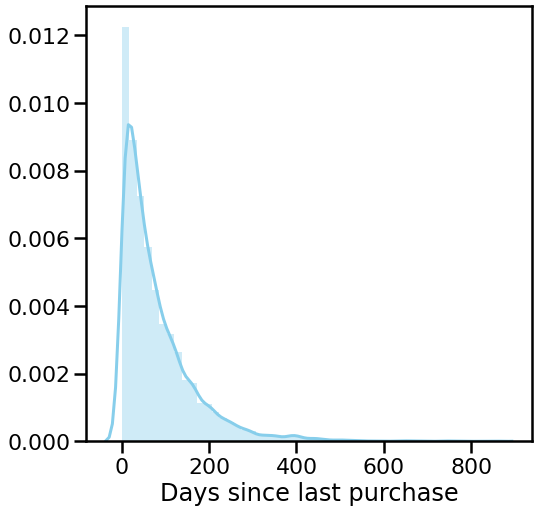

In [18]:
# Plotting for the last day since the customer made a purchase:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['skyblue'])
sns.distplot(rfm['recency'])
plt.xlabel('Days since last purchase')

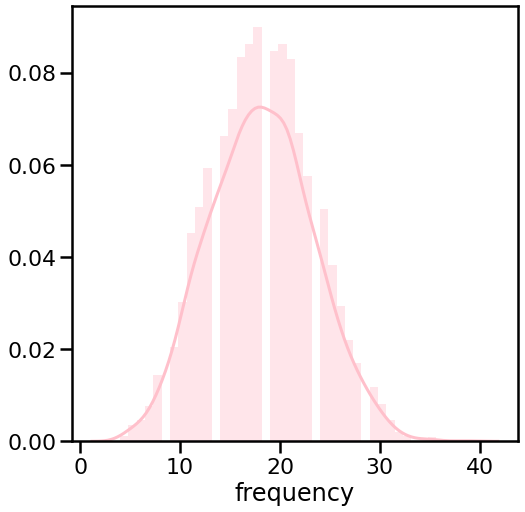

In [19]:
# Plotting the number of times the customer has made a purchase:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['pink'])
sns.distplot(rfm['frequency'])


Text(0.5, 0, 'Dollars')

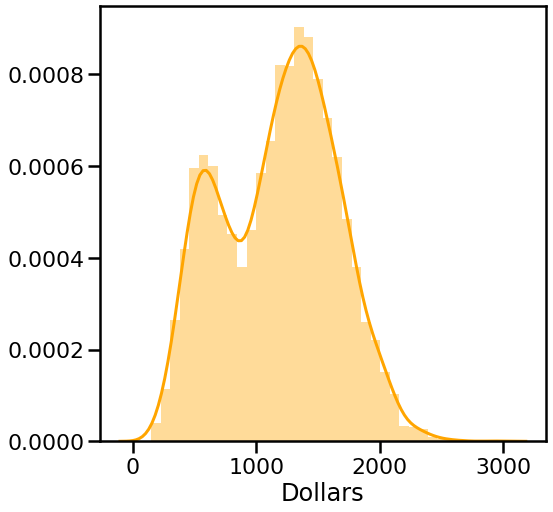

In [20]:
# Plotting the total revenue that the particular customer brought in to the shop:

plt.figure(figsize=(8,8))
sns.set_context("poster")
sns.set_palette(['orange'])
sns.distplot(rfm['monetary'])
plt.xlabel('Dollars')

Since we have a basic idea of what the distribution of the three indicators, lets use quantiles to educate ourselves further with quantiles:

#Visualizing the Recency, Frequency and Monetary distributions.
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(rfm.columns[1:4]):
    plt.subplot(gs[0,i])
    sns.distplot(rfm[var],color= col[i])
    plt.title('Skewness ' + ': ' + round(rfm[var].skew(),2).astype(str))
    i= i+1

RFM = rfm.head().reset_index()
RFM

In [21]:
#Segmentation :
#Here, we will divide the data set into 4 parts based on the quantiles.
quantiles = rfm.quantile(q = [0.25,0.5,0.75])
quantiles.to_dict()

{'recency': {0.25: 22.0, 0.5: 53.0, 0.75: 111.0},
 'frequency': {0.25: 14.0, 0.5: 18.0, 0.75: 22.0},
 'monetary': {0.25: 781.0, 0.5: 1227.0, 0.75: 1520.0}}

In [22]:
rfm.quantile([.25, .5, .75, 1], axis=0)

,recency,frequency,monetary
0.25,22.0,14.0,781.0
0.50,53.0,18.0,1227.0
0.75,111.0,22.0,1520.0
1.00,857.0,39.0,2933.0


In [23]:
#Creating the R,F and M scoring/segement function
#[1] Recency scoring (Negative Impact : Higher the value, less valuable)
def R_score(var,p,d):
    if var <= d[p][0.25]:
        return 1
    elif var <= d[p][0.50]:
        return 2
    elif var <= d[p][0.75]:
        return 3
    else:
        return 4
#[2] Frequency and Monetary (Positive Impact : Higher the value, better the customer)
def FM_score(var,p,d):
    if var <= d[p][0.25]:
        return 4
    elif var <= d[p][0.50]:
        return 3
    elif var <= d[p][0.75]:
        return 2
    else:
        return 1

#Scoring:
rfm['R_score'] = rfm['recency'].apply(R_score,args = ('recency',quantiles,))
rfm['F_score'] = rfm['frequency'].apply(FM_score,args = ('frequency',quantiles,))
rfm['M_score'] = rfm['monetary'].apply(FM_score,args = ('monetary',quantiles,))
rfm.head()

,recency,frequency,monetary,R_score,F_score,M_score
customer_id,,,,,,
CS1112,61,15,1012,3,3,3
CS1113,35,20,1490,2,2,2
CS1114,32,19,1432,2,2,2
CS1115,11,22,1659,1,2,1
CS1116,203,13,857,4,4,3


In [24]:
#Now we will create : RFMGroup and RFMScore
rfm['RFM_Group'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

#Score
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis = 1)
rfm.head()

,recency,frequency,monetary,R_score,F_score,M_score,RFM_Group,RFM_Score
customer_id,,,,,,,,
CS1112,61,15,1012,3,3,3,333,9
CS1113,35,20,1490,2,2,2,222,6
CS1114,32,19,1432,2,2,2,222,6
CS1115,11,22,1659,1,2,1,121,4
CS1116,203,13,857,4,4,3,443,11


# First will focus on the negativ and zero before the transformation.
def right_treat(var):
    if var <= 0:
        return 1
    else:
        return var

# Describing the data
RFM.describe()

#Applying on the data.
RFM['recency'] = RFM['recency'].apply(lambda x : right_treat(x))
RFM['monetary'] = RFM['monetary'].apply(lambda x : right_treat(x))

#Checking the Skewness of R, F and M
print('Recency Skewness : ' + RFM['recency'].skew().astype(str))
print('Frequency Skewness : ' + RFM['frequency'].skew().astype(str))
print('Monetary Skewness : ' + RFM['monetary'].skew().astype(str))

#Log Transformation
log_RFM_data = RFM[['recency','frequency','monetary']].apply(np.log,axis = 1).round(4)

#Plot after transformation for the distributions :
i = 0
fig = plt.figure(constrained_layout = True,figsize = (20,5))
gs = GridSpec(1, 3, figure=fig)    

col = ['red','blue','green']
for var in list(log_RFM_data.columns[0:3]):
    plt.subplot(gs[0,i])
    sns.distplot(log_RFM_data[var],color= col[i])
    plt.title('Skewness ' + ': ' + round(log_RFM_data[var].skew(),2).astype(str))
    i= i+1
log_RFM_data.describe()

Most Valuable Customers (MVCs):

In [25]:
# Using Quantiles we find the limit for our top 25% customers:
rfm.quantile([.75], axis=0)

,recency,frequency,monetary,R_score,F_score,M_score,RFM_Score
0.75,111.0,22.0,1520.0,3.0,4.0,4.0,10.0


The top customers would be the ones who are in the top 25% of the top RFM Scores:

In [26]:
topcustomers = rfm['RFM_Score'].iloc[[x >= 10 for x in rfm['RFM_Score']]]

In [27]:
MVCs = pd.DataFrame(topcustomers, columns = ['RFM_Score'])

In [28]:
MostValuableCustomers = list(MVCs.index)

In [29]:
MostValuableCustomers

['CS1116',
 'CS1117',
 'CS1129',
 'CS1144',
 'CS1150',
 'CS1167',
 'CS1168',
 'CS1193',
 'CS1197',
 'CS1212',
 'CS1213',
 'CS1224',
 'CS1239',
 'CS1242',
 'CS1282',
 'CS1288',
 'CS1297',
 'CS1309',
 'CS1310',
 'CS1314',
 'CS1325',
 'CS1328',
 'CS1329',
 'CS1333',
 'CS1335',
 'CS1341',
 'CS1346',
 'CS1375',
 'CS1379',
 'CS1386',
 'CS1408',
 'CS1418',
 'CS1436',
 'CS1481',
 'CS1482',
 'CS1487',
 'CS1500',
 'CS1514',
 'CS1521',
 'CS1522',
 'CS1523',
 'CS1524',
 'CS1530',
 'CS1532',
 'CS1536',
 'CS1554',
 'CS1562',
 'CS1563',
 'CS1565',
 'CS1590',
 'CS1591',
 'CS1595',
 'CS1618',
 'CS1638',
 'CS1651',
 'CS1657',
 'CS1665',
 'CS1672',
 'CS1682',
 'CS1688',
 'CS1700',
 'CS1701',
 'CS1716',
 'CS1756',
 'CS1762',
 'CS1765',
 'CS1777',
 'CS1784',
 'CS1801',
 'CS1808',
 'CS1834',
 'CS1839',
 'CS1845',
 'CS1852',
 'CS1881',
 'CS1882',
 'CS1891',
 'CS1896',
 'CS1899',
 'CS1915',
 'CS1917',
 'CS1918',
 'CS1956',
 'CS1962',
 'CS1965',
 'CS1973',
 'CS1979',
 'CS1983',
 'CS1984',
 'CS1994',
 'CS1997',